## Loading of Dataset

In [1]:
import numpy as np
dataset= np.load('/kaggle/input/data-preprocessing/final_pose_landmarks_dataset.npy')
labels = np.load('/kaggle/input/data-preprocessing/final_pose_landmarks_labels.npy')

## Label Encoding

In [2]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [3]:
import pickle
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

## Data Augmentation

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Attention, Concatenate, RepeatVector, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
import random

In [5]:
x_data = np.array(dataset, dtype=np.float32)

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

y_data = np.array(labels, dtype=np.int32)

def augment_landmarks(data, noise_factor=0.05, scale_factor=0.1, translation_factor=0.1, rotation_angle=10):
    augmented_data = []
    for sample in data:
        noisy_sample = sample + np.random.normal(loc=0.0, scale=noise_factor, size=sample.shape)
        scale = 1 + random.uniform(-scale_factor, scale_factor)
        scaled_sample = noisy_sample * scale

        translation = np.random.uniform(-translation_factor, translation_factor, size=(1, sample.shape[1]))
        translated_sample = scaled_sample + translation
        angle_rad = np.radians(random.uniform(-rotation_angle, rotation_angle))
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                    [np.sin(angle_rad), np.cos(angle_rad)]])
        
        if translated_sample.shape[1] == 3:  
            rotated_sample = np.copy(translated_sample)
            rotated_sample[:, :2] = np.dot(translated_sample[:, :2], rotation_matrix)
        else:
            rotated_sample = np.dot(translated_sample, rotation_matrix)

        augmented_data.append(rotated_sample)
    
    return np.array(augmented_data)

In [6]:
total_samples = len(x_data)
num_augmented_samples = int(0.3 * total_samples)
selected_indices = np.random.choice(total_samples, num_augmented_samples, replace=False)

augmented_samples = augment_landmarks(x_data[selected_indices])

x_data_augmented = np.concatenate([x_data, augmented_samples], axis=0)
y_data_augmented = np.concatenate([y_data, y_data[selected_indices]], axis=0)

print("Original x_data shape:", x_data.shape)
print("Augmented x_data shape:", augmented_samples.shape)
print("Final x_data_augmented shape:", x_data_augmented.shape)
print("Final y_data_augmented shape:", y_data_augmented.shape)

Original x_data shape: (229949, 111, 3)
Augmented x_data shape: (68984, 111, 3)
Final x_data_augmented shape: (298933, 111, 3)
Final y_data_augmented shape: (298933,)


## Train - Test Split

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(x_data_augmented, y_data_augmented, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

num_classes = len(np.unique(y_data))
print("Number of CLasses - words :",num_classes)

Number of CLasses - words : 262


## Model Architecture

In [8]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, BatchNormalization, Dense
input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]))

x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

x = Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)

x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Bidirectional(LSTM(256))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

In [9]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 111, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 111, 128)       │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 55, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 55, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 27, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 27, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 13, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,02

 Total params: 4,115,462 (15.70 MB)

 Trainable params: 4,110,086 (15.68 MB)

 Non-trainable params: 5,376 (21.00 KB)

None


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, verbose=1)

In [11]:
epochs = 100
batch_size = 128

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),  # Use test data as "validation" during training
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0188 - loss: 5.4823
Epoch 1: val_loss improved from inf to 4.30961, saving model to best_model.keras
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 60s 30ms/step - accuracy: 0.0188 - loss: 5.4821 - val_accuracy: 0.0807 - val_loss: 4.3096 - learning_rate: 1.0000e-04
Epoch 2/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0700 - loss: 4.3396
Epoch 2: val_loss improved from 4.30961 to 3.94947, saving model to best_model.keras
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 76s 29ms/step - accuracy: 0.0700 - loss: 4.3395 - val_accuracy: 0.1209 - val_loss: 3.9495 - learning_rate: 1.0000e-04
Epoch 3/100
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1258 - loss: 3.6815
Epoch 3: val_loss improved from 3.94947 to 3.09650, saving model to best_model.keras
1635/1635 ━━━━━━━━━━━━━━━━━━━━ 48s 29ms/step - accuracy: 0.1258 - loss: 3.6814 - val_accuracy: 0.2277 - val_loss: 3.0965 - learning_rate: 1.0000e-04
Epoch 4/100
1635/1635 ━━━━━━━━━━

## Results

In [12]:
val_loss, val_accuracy = model.evaluate(x_val, y_val, verbose=0)
print(f"Validation Accuracy (Holdout): {val_accuracy:.4f}, Validation Loss (Holdout): {val_loss:.4f}")

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

Validation Accuracy (Holdout): 0.7408, Validation Loss (Holdout): 1.7784
Test Accuracy: 0.7395, Test Loss: 1.7733


In [13]:
model.save("bestModel.h5")

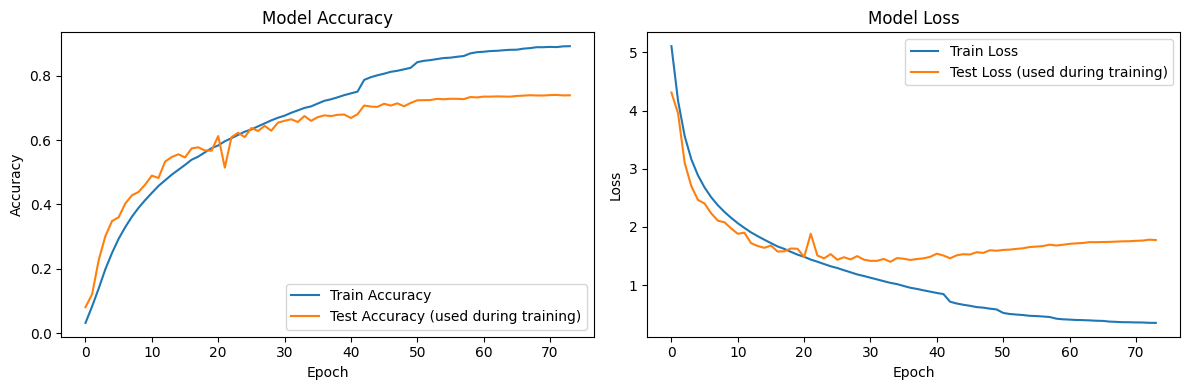

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy (used during training)')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss (used during training)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.metrics import top_k_categorical_accuracy
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
def top_k_accuracy(y_true, y_pred, k=5):
    return top_k_categorical_accuracy(y_true, y_pred, k)

top_5_accuracy = top_k_accuracy(np.eye(num_classes)[y_val], y_val_pred, k=3)
print(f"Top-3 Accuracy on Validation Set: {np.mean(top_5_accuracy):.4f}")

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Top-3 Accuracy on Validation Set: 0.8128


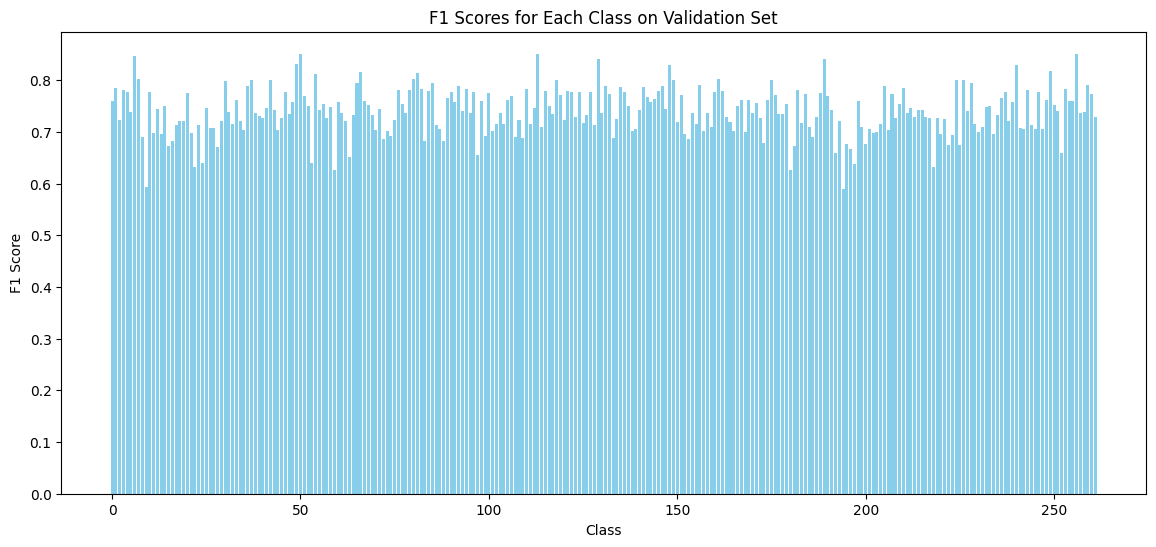

In [20]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_val, y_val_pred_classes, average=None)

plt.figure(figsize=(14, 6))
plt.bar(range(num_classes), f1_scores, color='skyblue')
plt.title('F1 Scores for Each Class on Validation Set')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.show()

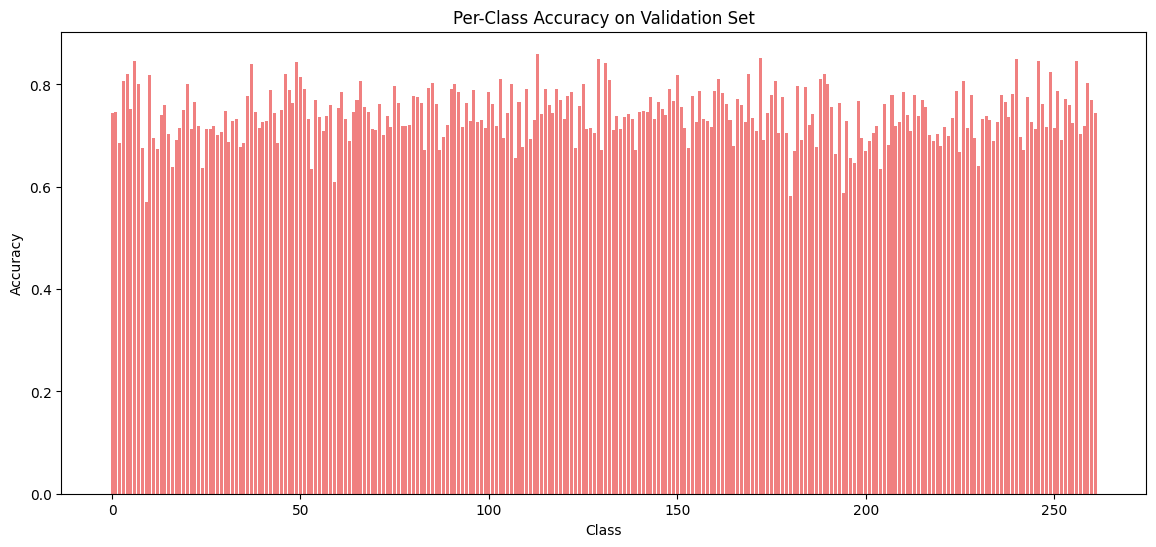

In [23]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

class_accuracy = np.diag(conf_matrix) / conf_matrix.sum(axis=1)

plt.figure(figsize=(14, 6))
plt.bar(range(num_classes), class_accuracy, color='lightcoral')
plt.title('Per-Class Accuracy on Validation Set')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.show()

In [34]:
import joblib

label_encoder = joblib.load('/kaggle/working/label_encoder.pkl')

y_true_labels = label_encoder.inverse_transform(y_true)
y_pred_labels = label_encoder.inverse_transform(y_pred_class)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

np.fill_diagonal(conf_matrix, 0)

misclassified_counts = conf_matrix_df.stack().reset_index()
misclassified_counts.columns = ['True Class', 'Predicted Class', 'Count']
misclassified_counts = misclassified_counts[misclassified_counts['Count'] > 0]

top_misclassified_pairs = misclassified_counts.sort_values(by='Count', ascending=False).head(10)

print("Top 10 Misclassified Class Pairs with Labels:")
print(top_misclassified_pairs)

Top 10 Misclassified Class Pairs with Labels:
         True Class Predicted Class  Count
66308  train ticket            Boat     21
63363           she              he     19
4214        Bicycle            Boat     18
21940       Husband            Wife     17
8045            Car           Truck     17
6967        Brother          Sister     17
58383       healthy           happy     17
4720           Bird          Animal     16
5949           Boat           Truck     15
7888            Car             Bus     15
